# Convolutional Neural Network (CNN)

Erstmal nur einfache Unterscheidung in Roboter / Ball.

In [1]:
!pip3 install tensorflow-gpu==1.15.3

     |████████████████████████████████| 411.0MB 43kB/s 
     |████████████████████████████████| 3.8MB 36.8MB/s 
     |████████████████████████████████| 512kB 39.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=e31cf92ddc4f965faa93e43186d8a985e0d3660b54f792808bb36fd68693fbeb
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling te

In [2]:
import os
import sys
import time
from datetime import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import models, optimizers, losses, activations
from tensorflow.python.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

Using TensorFlow backend.


In [3]:
print("Tensorflow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow Version: 1.15.3
Num GPUs Available:  1


## Parameter

In [0]:
#@title Prepare Parameter


#@markdown #### Prepare Data

FORCE = False #@param {type:"boolean"}

VALIDATION_SPLIT = 0.2 #@param {type:"number"}

IMAGE_FOLDER_NAME = "robot_ball_dataset" #@param {type:"string"}

DIMEN = 240 #@param {type:"integer"}

BATCH_SIZE = 64 #@param {type:"integer"}

#@markdown ---

#@markdown #### Load Data

DATA_FOLDER_PATH = "images/processed_data" #@param {type:"string"}

#@markdown ---

#@markdown #### Prepare Tensorflow Parameter

NUMBER_OF_CLASSES = 2 #@param {type:"integer"}
EPOCHS = 10 #@param {type:"integer"}
DROPOUT_RATE = 0.25 #@param {type:"number"}

MODEL_PATH = "models/" #@param {type:"string"}

## Prepare Data

### Download Data from HU Box

In [5]:
# Download image dataset from HU Box

if FORCE or not os.path.exists(IMAGE_FOLDER_NAME):
    print('download files')
    !rm *.zip
    !wget --content-disposition "https://box.hu-berlin.de/f/04d8587b0c0e4721b70d/?raw=1"
    !unzip -q -o robot_ball_dataset.zip

if not os.path.exists(MODEL_PATH):
    !mkdir models/

!ls -l

download files
rm: cannot remove '*.zip': No such file or directory
--2020-06-11 09:57:33--  https://box.hu-berlin.de/f/04d8587b0c0e4721b70d/?raw=1
Resolving box.hu-berlin.de (box.hu-berlin.de)... 141.20.184.42
Connecting to box.hu-berlin.de (box.hu-berlin.de)|141.20.184.42|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://box.hu-berlin.de/seafhttp/files/e18b5579-e625-4b34-b366-a92fed1f5160/robot_ball_dataset.zip [following]
--2020-06-11 09:57:34--  https://box.hu-berlin.de/seafhttp/files/e18b5579-e625-4b34-b366-a92fed1f5160/robot_ball_dataset.zip
Reusing existing connection to box.hu-berlin.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 315198599 (301M) [application/zip]
Saving to: ‘robot_ball_dataset.zip’

robot_ball_dataset. 100%[===================>] 300.60M  37.2MB/s    in 13s     

2020-06-11 09:57:47 (23.0 MB/s) - ‘robot_ball_dataset.zip’ saved [315198599/315198599]

total 307824
drwxr-xr-x 2 root root      4096 Jun 11 09:57 m

### Process Images

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255, 
    validation_split = VALIDATION_SPLIT
)

print("train dataset:")
train_generator = train_datagen.flow_from_directory( 
    IMAGE_FOLDER_NAME, 
    target_size = (DIMEN, DIMEN), 
    batch_size = BATCH_SIZE, 
    class_mode = 'binary',
    subset = 'training'
)

print("validation dataset:")
validation_generator = train_datagen.flow_from_directory( 
    IMAGE_FOLDER_NAME, 
    target_size = (DIMEN, DIMEN), 
    batch_size = BATCH_SIZE, 
    class_mode = 'binary',
    subset = 'validation'
)

train dataset:
Found 9332 images belonging to 2 classes.
validation dataset:
Found 2332 images belonging to 2 classes.


### Verify Data

first batch:


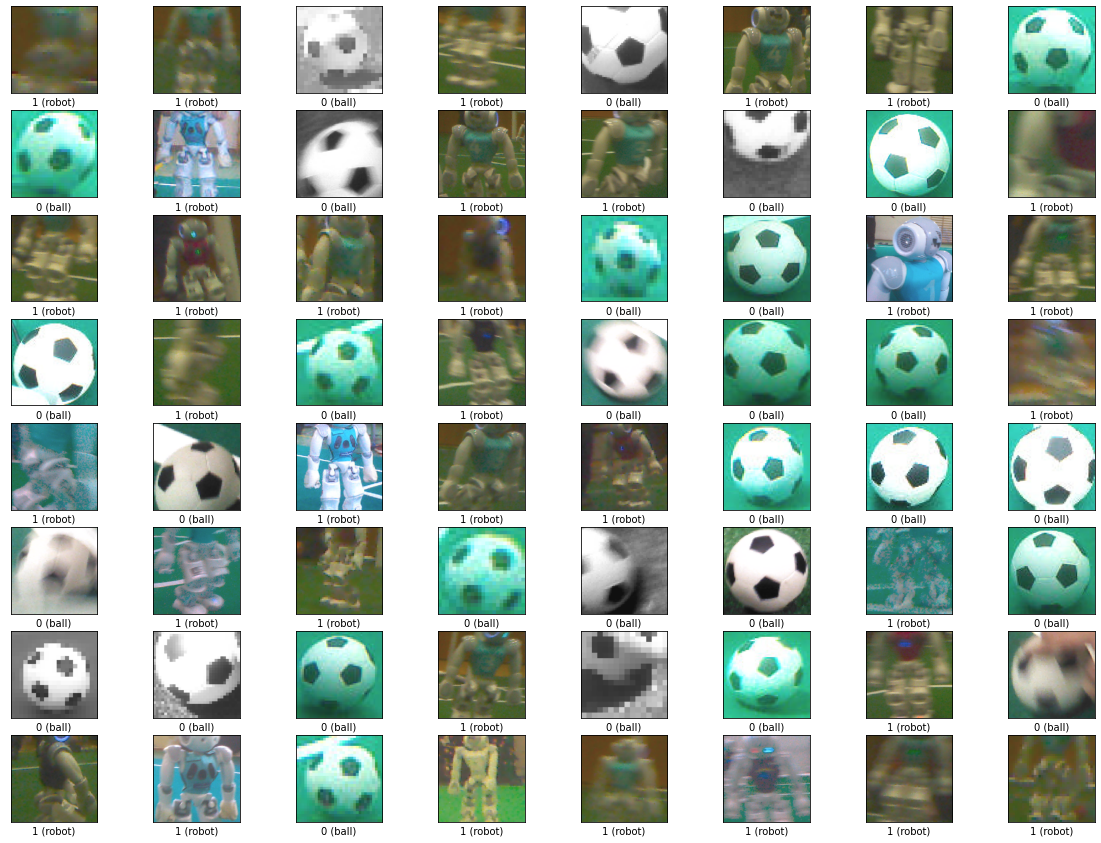

In [7]:
print('first batch:')
x,y = train_generator.next()

# kann vermutlich auch woanders her gelesen werden?

class_names = np.sort(next(os.walk(IMAGE_FOLDER_NAME))[1])
h_grid_size = 8

plt.figure(figsize=(20, 15))
for i in range (BATCH_SIZE):
    plt.subplot(BATCH_SIZE // h_grid_size, h_grid_size, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = x[i].squeeze()
    plt.imshow(image)

    label = int(y[i])
    plt.xlabel('{} ({})'.format(label, class_names[label]))

plt.show()

## Prepare Tensorflow Parameter

## Create neural network

In [8]:
activation_func = activations.relu

NEURAL_SCHEMA = [

    Conv2D(32, (3, 3), activation=activation_func, input_shape=(DIMEN, DIMEN, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation=activation_func),
    MaxPooling2D((2, 2)),

    Flatten(),
    
    Dense(100, activation=activation_func),
    Dropout(DROPOUT_RATE),

    Dense(NUMBER_OF_CLASSES, activation=tf.nn.softmax)
]

model = tf.keras.Sequential(NEURAL_SCHEMA)

model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Train Model

In [9]:
initial_time = time.time()

history = model.fit_generator(
    train_generator,
    #steps_per_epoch = train_generator.samples // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = validation_generator, 
    #validation_steps = validation_generator.samples // BATCH_SIZE,
)
    
final_time = time.time()
eta = (final_time - initial_time)
time_unit = 'seconds'
if eta >= 60:
    eta = eta / 60
    time_unit = 'minutes'
model.summary()
print('Elapsed time acquired for {} epoch(s) -> {} {}'.format(EPOCHS, eta, time_unit))

model_path = os.path.join(MODEL_PATH, 'model-{}.h5'.format(datetime.fromtimestamp(final_time).strftime("%Y-%m-%d_%H-%M")))
model.save(model_path)

Epoch 1/10
146/146 [==============================] - 41s 282ms/step - loss: 0.2150 - acc: 0.9501 - val_loss: 0.0028 - val_acc: 0.9991
Epoch 2/10
146/146 [==============================] - 32s 222ms/step - loss: 0.0307 - acc: 0.9880 - val_loss: 0.0026 - val_acc: 0.9991
Epoch 3/10
146/146 [==============================] - 33s 223ms/step - loss: 0.0176 - acc: 0.9926 - val_loss: 0.0091 - val_acc: 0.9966
Epoch 4/10
146/146 [==============================] - 33s 223ms/step - loss: 0.0090 - acc: 0.9968 - val_loss: 0.0033 - val_acc: 0.9987
Epoch 5/10
146/146 [==============================] - 33s 223ms/step - loss: 0.0036 - acc: 0.9994 - val_loss: 0.0031 - val_acc: 0.9991
Epoch 6/10
146/146 [==============================] - 33s 223ms/step - loss: 0.0099 - acc: 0.9964 - val_loss: 0.0035 - val_acc: 0.9987
Epoch 7/10
146/146 [==============================] - 33s 223ms/step - loss: 0.0141 - acc: 0.9957 - val_loss: 0.0045 - val_acc: 0.9991
Epoch 8/10
146/146 [==============================] - 3

## Evaluate Model

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

KeyError: ignored

## Predict